<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

In [4]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.2 MB 132 kB/s eta 0:00:01


# Отток клиентов

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import warnings                                                    # импортирую нужные библиотеки
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import sklearn
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

## Подготовка данных

In [6]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()                                      # загружаю и просматриваю датасет

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
df_knn = df.copy()      # создаю копию датасета для заполнения пропусков с помозью KNNImputer

In [8]:
df.info()    # просматриваю информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [9]:
imputer = KNNImputer(n_neighbors=2) 
                                       # заполняю пропуски
df_knn['Tenure'] = pd.DataFrame(imputer.fit_transform(df_knn['Tenure'].values.reshape(-1, 1))).apply(lambda x: round(x))
df_knn['Tenure'].value_counts()

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: Tenure, dtype: int64

In [10]:
df_group = df.copy()   # создаю датасет для замены пропусков по группе 

In [11]:
df_group['Tenure'] = df_group['Tenure'].fillna(df.groupby(['Gender', 'Age'])['Tenure'].transform('median'))
df_group['Tenure'].value_counts().head(40)       # заменяю пропуски медианой по группам 

5.0     1607
4.0      968
6.0      964
1.0      953
2.0      950
3.0      937
8.0      933
7.0      929
9.0      882
10.0     446
0.0      382
4.5       21
6.5       16
2.5        5
3.5        4
5.5        3
Name: Tenure, dtype: int64

In [12]:
describe = pd.DataFrame({'knn': list(df_knn['Tenure'].describe()), 
                         'no_knn': list(df['Tenure'].describe()),          # делаю сравнение по заполенению пропусков
                         'group': list(df_group['Tenure'].describe())},    
                        index=df.describe().index)
describe

,knn,no_knn,group
count,10000.00000,9091.000000,10000.000000
mean,4.99790,4.997690,4.996150
std,2.76001,2.894723,2.765732
min,0.00000,0.000000,0.000000
25%,3.00000,2.000000,3.000000
50%,5.00000,5.000000,5.000000
75%,7.00000,7.000000,7.000000
max,10.00000,10.000000,10.000000


In [14]:
df_knn['Exited'].value_counts() # увидел дисбаланс

0    7963
1    2037
Name: Exited, dtype: int64

In [15]:
df_knn[(df['Tenure'] == 10) & (df['Age'] < 28)]['Geography'].value_counts()

France     25
Spain      14
Germany    11
Name: Geography, dtype: int64

In [16]:
df_knn.dtypes  # просматриваю типы данных столбцов

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [17]:
df.duplicated().sum()  # просматриваю дубликаты

0

In [18]:
data = df_knn.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
data.dtypes            # удаляю столбцы, которые будут не нужны

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [19]:
df_ohe = pd.get_dummies(data, drop_first=True)     # произвожу one hot encoding
df_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [20]:
df_ohe.dtypes # просматриваю типы данных

CreditScore            int64
Age                    int64
Tenure               float64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Male            uint8
dtype: object

## Исследование задачи

In [21]:
# сделал переменную с признаками и переменную с целевым признаком, разбил данные на 80, 10, 10, произвел стандартизацию
warnings.filterwarnings('ignore')
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target) 

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9132,-0.154315,-0.564573,-0.002321,-1.224906,2,1,0,0.391985,0,0,0
9504,-0.928377,0.489338,-0.002321,1.065372,1,1,0,-0.030207,0,0,0
5059,0.588785,-0.947813,-0.366474,-1.224906,2,1,0,0.687560,0,0,1
9833,0.506219,0.201908,-1.458931,1.974685,2,1,0,-0.108757,1,0,0
9623,-0.794206,0.776768,1.090136,1.246027,1,1,0,-1.230891,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4285,-0.278165,0.106098,-0.002321,0.674350,1,1,0,1.607325,0,0,1
4103,0.341085,0.201908,-1.823083,1.155199,1,1,1,1.103997,0,1,1
8408,1.847927,-0.277143,-0.002321,0.082889,2,1,0,-0.178902,1,0,1
3771,-1.785006,-0.468763,1.090136,1.012843,2,1,1,1.555324,1,0,1


In [22]:
print('Размер тренировочной выборки:', features_train.shape[0])
print('Размер валидационной выборки:', features_valid.shape[0])
print('Размер тестовой выборки:', features_test.shape[0])

Размер тренировочной выборки: 8000
Размер валидационной выборки: 1000
Размер тестовой выборки: 1000


In [23]:
features_train_rs, features_test_rs, target_train_rs, target_test_rs = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train_rs[numeric])
features_train_rs[numeric] = scaler.transform(features_train_rs[numeric])
features_test_rs[numeric] = scaler.transform(features_test_rs[numeric])
features_train_rs

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3376,-0.061427,0.106098,-0.366474,0.010530,2,1,1,0.267707,1,0,0
1315,-0.443298,-1.139433,-0.002321,0.388533,1,0,0,-1.612531,0,1,0
2552,-0.525865,0.680958,0.725983,0.082043,2,1,0,-0.297533,0,1,0
511,-0.185277,-0.085522,0.361831,0.159218,2,1,0,-0.040122,1,0,0
1888,-2.280406,2.022299,0.725983,-1.224906,2,1,1,1.100176,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2360,-1.361852,0.201908,-0.002321,0.543826,1,1,0,-0.192448,1,0,0
4499,-1.176077,0.489338,-0.366474,0.724078,1,0,0,0.532043,1,0,0
1030,0.826165,0.010288,-1.458931,0.638360,1,0,0,0.787086,0,0,1
700,1.032581,-0.660383,-0.002321,-1.224906,2,1,0,-0.083220,0,0,0


In [21]:
forest = Pipeline([('classifier', RandomForestClassifier())])
forest_params = {
    'classifier__max_depth': list(range(1, 50, 2)),
    'classifier__n_estimators': list(range(1, 200, 5))
}

random_model = RandomizedSearchCV(forest,                            # пробую найти лучшую модель с помощью randomizedsearchcv
                                   forest_params,
                                   scoring = ['f1', 'roc_auc'],
                                   refit='f1', 
                                   n_iter = 300,
                                   cv = 4,
                                   verbose = 1,
                                   random_state=12345)

random_model.fit(features_train_rs, target_train_rs)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier())]),
                   n_iter=300,
                   param_distributions={'classifier__max_depth': [1, 3, 5, 7, 9,
                                                                  11, 13, 15,
                                                                  17, 19, 21,
                                                                  23, 25, 27,
                                                                  29, 31, 33,
                                                                  35, 37, 39,
                                                                  41, 43, 45,
                                                                  47, 49],
                                        'classifier__n_estimators': [1, 6, 11,
                                                                     16, 21, 26,
                         

In [22]:
print(random_model.best_params_)      # просматриваю лучшие результаты
print(random_model.best_score_)

{'classifier__n_estimators': 71, 'classifier__max_depth': 43}
0.5775584435115384


In [44]:
model = RandomForestClassifier(n_estimators = 71, max_depth=43, random_state=12345)
model.fit(features_train_rs, target_train_rs)
predictions = model.predict(features_test_rs)       
print(f1_score(target_test_rs, predictions))

0.5859491778774291


In [24]:
warnings.filterwarnings('ignore')
dtc = DecisionTreeClassifier(random_state=12345)
param_tree = {
    'max_depth': list(range(1, 100))                    # ищу лучшие параметры с помощью gredsearchcv
}

gsc_tree = GridSearchCV(dtc, param_tree, scoring='f1')
gsc_tree.fit(features_valid, target_valid)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='f1')

In [25]:
print(gsc_tree.best_params_)   #  просматриваю лучшие результаты
print(gsc_tree.best_score_)

{'max_depth': 7}
0.5550698953389548


In [26]:
model = DecisionTreeClassifier(max_depth=7, random_state=12345)
model.fit(features_train, target_train)           # просматриваю результат предсказания на тестовой выборке
predictions = model.predict(features_test)
dtc_score = f1_score(target_test, predictions)    # передаю в переменную лучший результат предсказания
print(dtc_score)

0.5263157894736843


In [27]:
best_model = None
best_result = 0
for depth in range(1, 15):
    for est in range(1,50):
        model = RandomForestClassifier(n_estimators = est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)             # с помощью цикла ищу лучшие параметры 
        if f1_score(target_valid, predictions_valid) > best_result:
            best_result = f1_score(target_valid, predictions_valid)
            best_est = est
            best_depth = depth
        
print('Наилучшая модель показала результат {}, количество деревьев {}, глубина {}'.format(best_result, best_est, best_depth))

Наилучшая модель показала результат 0.6246418338108882, количество деревьев 20, глубина 14


In [28]:
model = RandomForestClassifier(n_estimators = 20, max_depth=14, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)       # передаю в переменную лучший результат предсказания
rfc_score = f1_score(target_test, predictions)
print(rfc_score)

0.563467492260062


In [29]:
model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced', random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
lr_score = f1_score(target_test, predictions)           # передаю в переменную лучший результат предсказания
print(lr_score)

0.5128205128205129


In [30]:
score = pd.DataFrame({'LogisticRegression':lr_score, 
                      'RandomForestClassifier': rfc_score,     # создаю датафрейм лучших результатов 3 моделей
                      'DecisionTreeClassifier': dtc_score},
                      index = [1])
score                     

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier
1,0.512821,0.563467,0.526316


## Борьба с дисбалансом

In [32]:
target_train.value_counts() # проверяю дисбаланс 

0    6370
1    1630
Name: Exited, dtype: int64

In [33]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) # пишу функцию для того, чтобы убрать дисбаланс
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4) # приминяю апсемплинг

In [34]:
target_upsampled.value_counts() # удостоверился, что всё сработало и дисбаланса нет

1    6520
0    6370
Name: Exited, dtype: int64

In [35]:
best_model = None
best_result = 0
for depth in range(1, 50):
    for est in range(1,100,5):
        model = RandomForestClassifier(n_estimators = est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)           # пишу цикл для выявления лучших параметров
        if f1_score(target_valid, predictions_valid) > best_result:
            best_result = f1_score(target_valid, predictions_valid)
            best_est = est
            best_depth = depth
        
print('Наилучшая модель показала результат {}, количество деревьев {}, глубина {}'.format(best_result, best_est, best_depth))

Наилучшая модель показала результат 0.6727272727272727, количество деревьев 11, глубина 12


## Тестирование модели

In [36]:
model = RandomForestClassifier(n_estimators = 11, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)        # проверяю лучшие параметры модели
print(f1_score(target_test, predictions))

0.5972222222222221


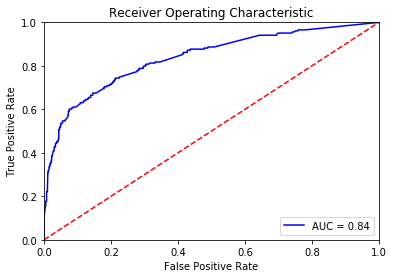

In [37]:
model = RandomForestClassifier(n_estimators = 11, max_depth=16, random_state=12345)
model.fit(features_upsampled, target_upsampled)
probs = model.predict_proba(features_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(target_test, preds)


roc_auc = metrics.auc(fpr, tpr)                         # строю график ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
best_model = None
best_result = 0
for depth in range(1, 25):
    for est in range(1,150,15):
        model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=est, random_state=12345,
                        algorithm='SAMME.R', learning_rate=0.5)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        if f1_score(target_valid, predictions_valid) > best_result:
            best_model = model
            best_result = f1_score(target_valid, predictions_valid)
            best_est = est
            best_depth = depth
        
print('Наилучшая модель показала результат {}, количество деревьев {}, глубина {}'.format(best_result, best_est, best_depth))

Наилучшая модель показала результат 0.6442687747035574, количество деревьев 46, глубина 2


In [39]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=46, random_state=12345,
                        algorithm='SAMME.R', learning_rate=0.5)
clf.fit(features_upsampled, target_upsampled)
predictions = clf.predict(features_test)
print(f1_score(target_test, predictions))

0.593186372745491


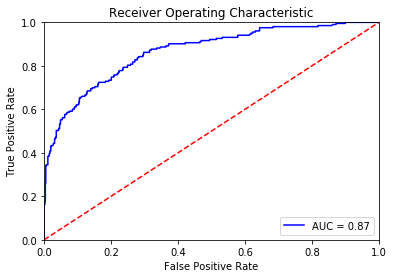

In [40]:
probs = clf.predict_proba(features_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(target_test, preds)


roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()